In [100]:
def normalize(df):
    return df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace("'"," ").str.replace('-','').str.replace(' ','_').str.lower()

In [66]:
import pandas as pd
import numpy as np
import geopandas as gpd

pd.options.display.max_columns=999
pd.options.display.max_rows=999


import plotly.express as px
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

In [101]:
df        = pd.read_csv('../data/SIHSUS/sihsus_municipios.csv')
df.columns = normalize(df.columns)

municipios = pd.read_csv('../data/Codigos/br_municipios_ibge.csv')

mask = municipios['sigla_uf']=='SP'
municipios = municipios[mask]

cols = ['geocodigo','nome_municip_ibge','nome_microrregiao','nome_mesorregiao','sigla_uf']
municipios = municipios[cols]

maps = gpd.read_file('../data/Codigos/sp_municipios.json')

In [102]:
df['co_ibge'] = df['municipio'].apply(lambda x: x[:6]).str.strip()
df['data'] = pd.to_datetime(df['ano'].astype(str) + "-" + df['mes'].astype(str))

mask = df['municipio']!='Total'

df = df[mask]



municipios['co_ibge'] = municipios['geocodigo'].apply(lambda x: str(x)[:6]).str.strip()


In [103]:
df_municipios = pd.merge(municipios, df, on='co_ibge', how='right')

mask = df_municipios['sigla_uf'].notnull()
df_municipios = df_municipios[mask]



cols = ['geocodigo','geometry']

df_municipios = pd.merge(df_municipios, maps[cols], on='geocodigo', how='left')

df_municipios = gpd.GeoDataFrame(df_municipios)

In [104]:
df_municipios.columns

Index(['geocodigo', 'nome_municip_ibge', 'nome_microrregiao',
       'nome_mesorregiao', 'sigla_uf', 'co_ibge', 'municipio', 'aih_aprovadas',
       'internacoes', 'valor_total', 'valor_servicos_hospitalares',
       'val_serv_hosp__compl_federal', 'val_serv_hosp__compl_gestor',
       'valor_servicos_profissionais', 'val_serv_prof__compl_federal',
       'val_serv_prof__compl_gestor', 'valor_medio_aih', 'valor_medio_intern',
       'dias_permanencia', 'media_permanencia', 'obitos', 'taxa_mortalidade',
       'ano', 'mes', 'data', 'geometry'],
      dtype='object')

In [105]:
variaveis = ['aih_aprovadas','internacoes', 'valor_total', 'valor_servicos_hospitalares',
       'val_serv_hosp__compl_federal', 'val_serv_hosp__compl_gestor',
       'valor_servicos_profissionais', 'val_serv_prof__compl_federal',
       'val_serv_prof__compl_gestor', 'valor_medio_aih', 'valor_medio_intern',
       'dias_permanencia', 'media_permanencia', 'obitos', 'taxa_mortalidade']

for col in variaveis:
    df_municipios[col] = pd.to_numeric(df_municipios[col], errors='coerce')


In [ ]:
sum_cols =  ['aih_aprovadas','internacoes', 'valor_total', 'valor_servicos_hospitalares',
       'val_serv_hosp__compl_federal', 'val_serv_hosp__compl_gestor',
       'valor_servicos_profissionais', 'val_serv_prof__compl_federal',
       'val_serv_prof__compl_gestor', 'valor_medio_aih',
       'dias_permanencia', 'obitos']
mean_cols = ['valor_medio_aih','media_permanencia']


group_cols = ['nome_municip_ibge','nome_microrregiao','nome_mesorregiao','geometry','ano']
df_municipios_ano_sum  = df_municipios[group_cols + sum_cols].groupby(by=group_cols, as_index=False).sum()
df_municipios_ano_mean = df_municipios[group_cols + mean_cols].groupby(by=group_cols, as_index=False).mean()

In [5]:
ano = 2019
mes = 9

mask = (df_hospitais['ano']==ano) & (df_hospitais['mes']==mes) & (df_hospitais['lat'].notnull())

hospitais_assis = df_hospitais[mask]


locations = hospitais_assis[['lat', 'lng']]
locationlist = locations.values.tolist()

In [6]:
map2 = folium.Map(location=[-22.157651, -48.054817], zoom_start=7, tiles='CartoDB dark_matter')

marker_cluster = MarkerCluster().add_to(map2)


variavel = 'AIH aprovadas'

hospitais_assis['var'] = pd.to_numeric(hospitais_assis[variavel], errors='coerce').fillna(1)


variable = hospitais_assis[variavel].tolist()
var      = hospitais_assis['var'].tolist()
hospitais = hospitais_assis['hospital'].tolist()
municipio = hospitais_assis['administrative_area_level_2'].tolist()


factor = 30/max(var)

for i in range(0, len(locationlist)):
    string = "Municipio: " + str(municipio[i]) +  '<br>' '<br>'+ str(hospitais[i]) +  '<br>' '<br>'+ str(variavel) + ": " + str(variable[i])
#     print(string)
#     
    folium.Marker(locationlist[i], popup=(string),).add_to(marker_cluster)
    
    folium.CircleMarker(location=locationlist[i],
                            radius= var[i] * factor,
                            color="#007849",
                            popup=string,
                            fill=False).add_to(map2)
#     print(var[i])

# HeatMap(data=hospitais_assis[['lat','lng','var']].values.tolist(), radius=20, max_zoom=13).add_to(map2)

    
map2

/home/m/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/home/m/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



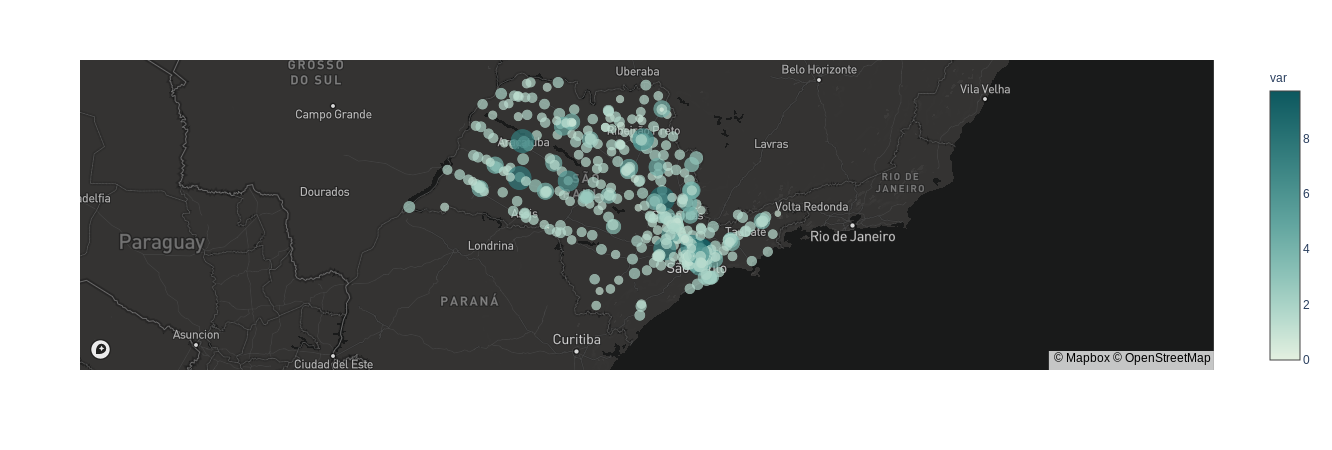

In [179]:


import plotly.express as px
token = open("../../mapbox_token").read()

variavel = 'Média permanência'

hospitais_assis['var'] = np.log(pd.to_numeric(hospitais_assis[variavel], errors='coerce').fillna(0) +1 )

dd="var"
fig = px.scatter_mapbox(hospitais_assis, lat="lat", lon="lng", color="var", size="var", hover_name='hospital',
                        color_continuous_scale=px.colors.carto.Mint, size_max=20, zoom=5)

fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
fig.show()



### Graphs

In [9]:
from ipywidgets import interact

In [10]:
df_hospitais.columns

Index(['co_cnes', 'lat', 'lng', 'administrative_area_level_2',
       'Estabelecimento', 'AIH aprovadas', 'Internações', 'Valor total',
       'Valor serviços hospitalares', 'Val serv hosp - compl federal',
       'Val serv hosp - compl gestor', 'Valor serviços profissionais',
       'Val serv prof - compl federal', 'Val serv prof - compl gestor',
       'Valor médio AIH', 'Valor médio intern', 'Dias permanência',
       'Média permanência', 'Óbitos', 'Taxa mortalidade', 'ano', 'mes',
       'hospital', 'Data'],
      dtype='object')

In [175]:
cidades = df_hospitais['administrative_area_level_2'].unique().tolist()
variaveis = ['AIH aprovadas', 'Internações', 'Valor total',
       'Valor serviços hospitalares', 'Val serv hosp - compl federal',
       'Val serv hosp - compl gestor', 'Valor serviços profissionais',
       'Val serv prof - compl federal', 'Val serv prof - compl gestor',
       'Valor médio AIH', 'Valor médio intern', 'Dias permanência',
       'Média permanência', 'Óbitos', 'Taxa mortalidade']

In [176]:
df_hospitais_norm = df_hospitais.copy()
mask = df_hospitais_norm['administrative_area_level_2']=='Taubaté'
df_hospitais_norm = df_hospitais_norm[mask]

hospitais = df_hospitais_norm['hospital'].unique().tolist()


df_hospital_norm = pd.DataFrame()

for hospital in hospitais:
    mask = df_hospitais_norm['hospital']==hospital
    df_hospital = df_hospitais_norm[mask]

    for col in variaveis:
        df_hospital[col] = pd.to_numeric(df_hospital[col], errors='coerce')
        df_hospital[col]= (df_hospital[col]-df_hospital[col].min())/(df_hospital[col].max()-df_hospital[col].min())
    
    df_hospital_norm = pd.concat([df_hospital_norm,df_hospital],axis=0)
    
    
n_hospitais = len(hospitais)

/home/m/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/m/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



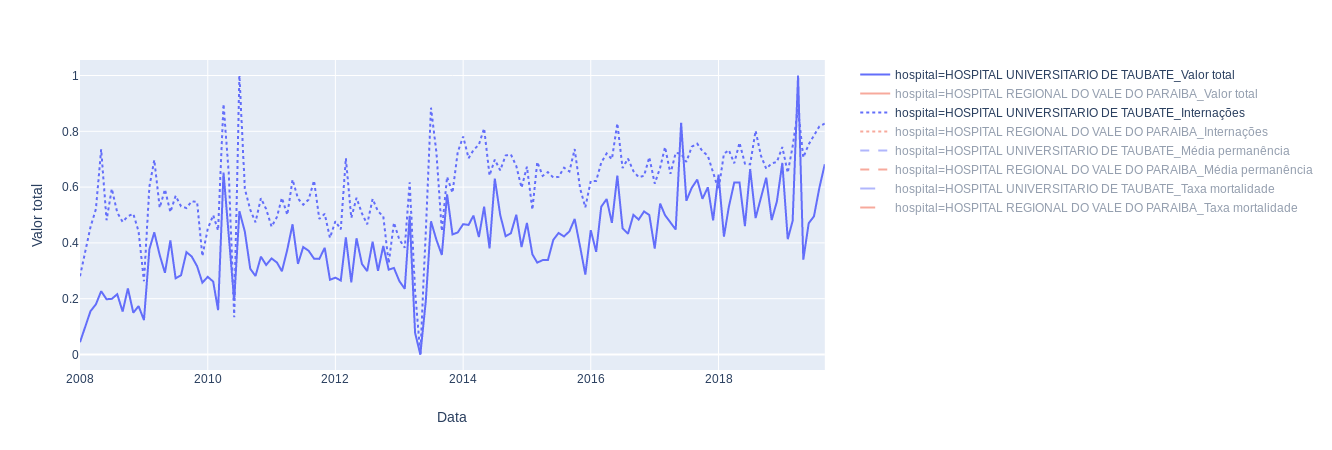

In [177]:
var = 'Valor total'
df_plot = df_hospital_norm.copy()
df_plot['hospital'] = df_plot['hospital'] + "_" + var
fig  = px.line(df_plot, x = 'Data', y=var, color='hospital')

mult_vars = ['Internações','Média permanência','Taxa mortalidade']

# dash_list = ["solid","dot","dash","longdash","dashdot","longdashdot"]
dash_list = ["dot","dash","longdash"]

for var,dash in zip(mult_vars,dash_list):
    df_plot = df_hospital_norm.copy()
    df_plot['hospital'] = df_plot['hospital'] + "_" + var
    
    fig2  = px.line(df_plot, x = 'Data', y=var, color='hospital', line_dash_sequence=[dash for i in range(n_hospitais)])
    
    for i in range(n_hospitais):
        fig.add_trace(fig2.data[i])

fig.show()

### Cluester Analysis

In [109]:
variaveis = ['AIH aprovadas', 'Internações', 'Valor total',
       'Valor serviços hospitalares', 'Val serv hosp - compl federal',
       'Val serv hosp - compl gestor', 'Valor serviços profissionais',
       'Val serv prof - compl federal', 'Val serv prof - compl gestor',
       'Valor médio AIH', 'Valor médio intern', 'Dias permanência',
       'Média permanência', 'Óbitos', 'Taxa mortalidade']

In [142]:
df_hospitais_ano = df_hospitais.copy()
for col in variaveis:
    df_hospitais_ano[col] = pd.to_numeric(df_hospitais_ano[col], errors='coerce')


df_hospitais_ano_g = df_hospitais_ano.groupby(by=['hospital','ano','lat','lng','co_cnes'], as_index=False).sum()
df_hospitais_ano_g['ano'] = df_hospitais_ano_g['ano'].astype(str)

In [143]:
df_hospitais_ano_g['folha_x_servicos'] = df_hospitais_ano_g['Valor serviços profissionais']/df_hospitais_ano_g['Valor total']

In [158]:
df_hospitais_ano_g['media_permanencia'] = df_hospitais_ano_g['Dias permanência']/df_hospitais_ano_g['Internações']

In [160]:
# df_hospitais_ano_g[['hospital','media_permanencia','Média permanência']]

In [148]:
from sklearn.cluster import KMeans


df_hospitais_ano_g['cluster'] = KMeans(n_clusters=7, random_state=42).fit_predict(df_hospitais_ano_g['Internações'].values.reshape(-1,1))
df_hospitais_ano_g['cluster'] = df_hospitais_ano_g['cluster'].astype(str)

# df_hospitais_ano_g['cluester_ano'] = df_hospitais_ano_g['ano'].astype(str) + '_' + df_hospitais_ano_g['cluester'].astype(str)

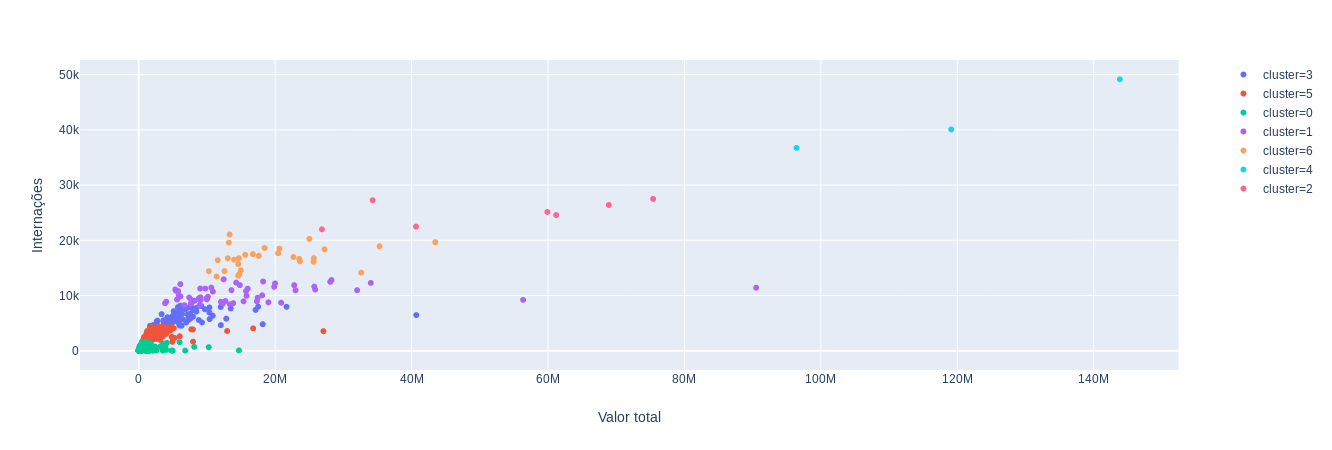

In [178]:
var1 = 'Valor total'
var2 = 'Internações'


mask = df_hospitais_ano_g['ano']=='2018'

px.scatter(df_hospitais_ano_g[mask], x = var1, y=var2,  color='cluster', hover_name='hospital')
